In [1]:
import numpy as np
from numpy import concatenate
import pandas as pd
import tensorflow as tf
import keras
import math
import seaborn as sns
from scipy.optimize import curve_fit
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
solar_data = pd.read_csv('./data/train/train.csv',encoding='utf-8')

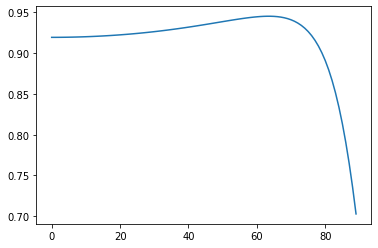

63 0.9451229383187165


In [3]:
corrList = []
corr = lambda p : p['TARGET'].corr(p['GHI'])

def makeCorrList(df):
    result = corr(df)
    corrList.append(result)

for i in range(0,90):
    solar_data['GHI'] = solar_data['DNI']*math.cos(math.pi/180*i)+solar_data['DHI']
    makeCorrList(solar_data)

x = np.arange(0,90)
plt.plot(x,corrList)
plt.show()

print(corrList.index(max(corrList)), max(corrList))

In [4]:
solar_data['GHI'] = solar_data['DNI']*math.cos(math.pi/180*63)+solar_data['DHI']

In [5]:
def eval_dewpoint(T, RH):
    b = 17.62
    c = 243.12
    gamma = (b * T / (c + T)) + math.log(RH / 100.0)
    dewpoint = (c * gamma) / (b - gamma)
    return dewpoint

In [6]:
for i in range(len(solar_data)):
    solar_data.loc[i, ["DP"]] = eval_dewpoint(float(solar_data.loc[i, ["T"]]), solar_data.loc[i , ["RH"]])

In [7]:
solar_data = solar_data.reindex(columns=["Day", "Hour", "Minute", "GHI", "DHI", "DNI", "WS", "RH", "T", "DP", "TARGET"])

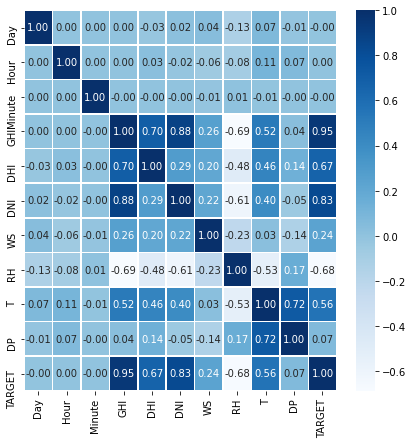

In [8]:
mask = (solar_data.Hour==12)&(solar_data.Minute==00)
# solar_data_filtered = solar_data.loc[mask,:]
# solar_data_filtered.drop(['Day', 'Hour','Minute'], axis='columns', inplace=True)
plt.figure(figsize=(7, 7))
# sns.heatmap(data=solar_data_filtered.corr(), annot=True,fmt='.2f', linewidths=.5, cmap='Blues')
sns.heatmap(data=solar_data.corr(), annot=True,fmt='.2f', linewidths=.5, cmap='Blues')
plt.rcParams['font.family'] = 'NanumGothic'

In [9]:
solar_data.drop(['Day', 'Hour','Minute'], axis='columns', inplace=True)

In [10]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

def create_dataset(solar_data, index):
    dataX, dataY = [], []
    for i in range(0,48*7):
        dataX.append(list(np.array(solar_data.loc[index+i].tolist())))
    for i in range(48*7,48*7+48*2):
        dataY.append(solar_data.loc[index+i,'TARGET'])
    return np.array(dataX), np.array(dataY)

In [11]:
# 데이터셋 생성
input_data, output_data = [], []

last_index = 3*365*48-48*9
list_index = list(range(0,last_index,48))

# last_index = 3*365*48 - 432
# list_index = list(0:last_index,1))

for i in list_index:
    X, Y = create_dataset(solar_data,i)
    input_data.append(X)
    output_data.append(Y)

In [12]:
input_array = np.array(input_data)
output_array = np.reshape(np.array(output_data),(1086,96,1))

In [13]:
# 데이터셋 분배
train_x, test_x, train_y, test_y = train_test_split(input_array, output_array, test_size = 78/1086,shuffle = True)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=48*3/1008,shuffle=True)

# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
# train_x = train_x.reshape((train_x.shape[0], 7, 1, 48, 6))

In [14]:
# 돌려!

import keras.backend as K

submission = pd.read_csv('./data/sample_submission.csv')
submission.set_index('id',inplace=False)
test = []
for i in range(81):
    data = []
    tmp = pd.read_csv(f'./data/test/{i}.csv')
    tmp['GHI'] = tmp['DNI']*math.cos(math.pi/180*63)+tmp['DHI']
    for i in range(len(tmp)):
      tmp.loc[i, ["DP"]] = eval_dewpoint(float(tmp.loc[i, ["T"]]), tmp.loc[i , ["RH"]])
    tmp = tmp.reindex(columns=["Day", "Hour", "Minute", "GHI", "DHI", "DNI", "WS", "RH", "T", "DP", "TARGET"])
    tmp.drop(['Day', 'Hour','Minute'], axis='columns', inplace=True)
    for i in range(0,48*7):
        data.append(list(np.array(tmp.loc[i].tolist())))
    test.append(data)
test = np.array(test)

In [15]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

def sun_rise(test_data,prediction_data):
  sun_time=[]
  test_data = np.reshape(test_data,(336,8))
  for i in range(48):
      if (test_data[288 + i, -1])>0:
          sun_time.append(1)
      else:
          sun_time.append(0)
  sum_time = np.array(sun_time + sun_time)
  pre_data = np.reshape(prediction_data,(96))
  ans = sum_time * pre_data
  return ans

In [16]:
n_batch = 8

for l, q in enumerate(np.arange(0.1, 1, 0.1)):
  print(q)
  model = Sequential()
  for i in range(2):
      model.add(LSTM(128, batch_input_shape=(8, 336, 8), stateful=True, return_sequences=True))
      model.add(Dropout(0.3))
  model.add(LSTM(128, batch_input_shape=(8, 336, 8), stateful=True, return_sequences=True))
  model.add(Dropout(0.3))
  model.add(LSTM(64, return_sequences=True))
  model.add(Dropout(0.3))
  model.add(LSTM(16))
  model.add(Dropout(0.3))
  model.add(Dense(96))
  model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adam')
  for j in range(500):
    # model.fit(train_x, train_y, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(val_x, val_y))
    model.fit(train_x, train_y, epochs=1, batch_size=n_batch, shuffle=False, validation_data=(val_x, val_y),  verbose=2)
    model.reset_states()
  weights = model.get_weights()
  
  single_item_model = Sequential()
  for i in range(2):
      single_item_model.add(LSTM(128, batch_input_shape=(1, 336, 8), stateful=True, return_sequences=True))
      single_item_model.add(Dropout(0.3))
  single_item_model.add(LSTM(128, batch_input_shape=(1, 336, 8), stateful=True, return_sequences=True))
  single_item_model.add(Dropout(0.3))
  single_item_model.add(LSTM(64, return_sequences=True))
  single_item_model.add(Dropout(0.3))
  single_item_model.add(LSTM(16))
  single_item_model.add(Dropout(0.3))
  single_item_model.add(Dense(96))
  single_item_model.set_weights(weights)
  single_item_model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adam')
  
  predictions = []
  for k in range(81):
    prediction = single_item_model.predict(np.array([test[k]]), batch_size=1)
    predictions.append(sun_rise(np.array([test[k]]),prediction))
  predictions = np.reshape(np.concatenate(np.array(predictions), axis=0),(81*96))
  submission.iloc[:,l+1] = predictions
submission.to_csv(f'submission.csv', index=False)
print('finish')

0.1
108/108 - 18s - loss: 1.7784 - val_loss: 1.8338
108/108 - 7s - loss: 1.7214 - val_loss: 1.7203
108/108 - 7s - loss: 1.6398 - val_loss: 1.6696
108/108 - 7s - loss: 1.5981 - val_loss: 1.6367
108/108 - 7s - loss: 1.5676 - val_loss: 1.6136
108/108 - 7s - loss: 1.5483 - val_loss: 1.5981
108/108 - 7s - loss: 1.5362 - val_loss: 1.5867
108/108 - 7s - loss: 1.5294 - val_loss: 1.5789
108/108 - 7s - loss: 1.5219 - val_loss: 1.5728
108/108 - 7s - loss: 1.5181 - val_loss: 1.5679
108/108 - 7s - loss: 1.5172 - val_loss: 1.5642
108/108 - 7s - loss: 1.5141 - val_loss: 1.5619
108/108 - 7s - loss: 1.5073 - val_loss: 1.5597
108/108 - 7s - loss: 1.5050 - val_loss: 1.5578
108/108 - 7s - loss: 1.5053 - val_loss: 1.5563
108/108 - 7s - loss: 1.5021 - val_loss: 1.5550
108/108 - 7s - loss: 1.4975 - val_loss: 1.5540
108/108 - 7s - loss: 1.4991 - val_loss: 1.5532
108/108 - 7s - loss: 1.5005 - val_loss: 1.5527
108/108 - 7s - loss: 1.4937 - val_loss: 1.5522
108/108 - 7s - loss: 1.5026 - val_loss: 1.5518
108/108 

In [ ]:
n_batch = 8

for l, q in enumerate(np.arange(0.1, 1, 0.1)):
  print(q)
  model = Sequential()
  for i in range(2):
      model.add(LSTM(64, batch_input_shape=(8, 336, 8), stateful=True, return_sequences=True))
      model.add(Dropout(0.3))
  model.add(LSTM(64, batch_input_shape=(8, 336, 8), stateful=True, return_sequences=True))
  model.add(Dropout(0.3))
  model.add(LSTM(64, return_sequences=True))
  model.add(Dropout(0.3))
  model.add(LSTM(16))
  model.add(Dropout(0.3))
  model.add(Dense(96))
  model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adam')
  for j in range(500):
    # model.fit(train_x, train_y, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(val_x, val_y))
    model.fit(train_x, train_y, epochs=1, batch_size=n_batch, shuffle=False, validation_data=(val_x, val_y),  verbose=2)
    model.reset_states()
  weights = model.get_weights()
  
  single_item_model = Sequential()
  for i in range(2):
      single_item_model.add(LSTM(64, batch_input_shape=(1, 336, 8), stateful=True, return_sequences=True))
      single_item_model.add(Dropout(0.3))
  single_item_model.add(LSTM(64, batch_input_shape=(1, 336, 8), stateful=True, return_sequences=True))
  single_item_model.add(Dropout(0.3))
  single_item_model.add(LSTM(64, return_sequences=True))
  single_item_model.add(Dropout(0.3))
  single_item_model.add(LSTM(16))
  single_item_model.add(Dropout(0.3))
  single_item_model.add(Dense(96))
  single_item_model.set_weights(weights)
  single_item_model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adam')
  
  predictions = []
  for k in range(81):
    prediction = single_item_model.predict(np.array([test[k]]), batch_size=1)
    predictions.append(sun_rise(np.array([test[k]]),prediction))
  predictions = np.reshape(np.concatenate(np.array(predictions), axis=0),(81*96))
  submission.iloc[:,l+1] = predictions
submission.to_csv(f'submission.csv_1', index=False)
print('finish')

0.1
108/108 - 13s - loss: 1.7781 - val_loss: 1.8346
108/108 - 6s - loss: 1.7315 - val_loss: 1.7264
108/108 - 6s - loss: 1.6403 - val_loss: 1.6696
108/108 - 6s - loss: 1.5950 - val_loss: 1.6355
108/108 - 6s - loss: 1.5657 - val_loss: 1.6120
108/108 - 6s - loss: 1.5459 - val_loss: 1.5965
108/108 - 6s - loss: 1.5340 - val_loss: 1.5850
108/108 - 6s - loss: 1.5262 - val_loss: 1.5768
108/108 - 6s - loss: 1.5180 - val_loss: 1.5706
108/108 - 6s - loss: 1.5151 - val_loss: 1.5661
108/108 - 6s - loss: 1.5080 - val_loss: 1.5627
108/108 - 6s - loss: 1.5055 - val_loss: 1.5601
108/108 - 6s - loss: 1.5019 - val_loss: 1.5581
108/108 - 6s - loss: 1.5036 - val_loss: 1.5564
108/108 - 6s - loss: 1.4988 - val_loss: 1.5551
108/108 - 6s - loss: 1.5010 - val_loss: 1.5541
108/108 - 6s - loss: 1.5009 - val_loss: 1.5534
108/108 - 6s - loss: 1.5024 - val_loss: 1.5527
108/108 - 6s - loss: 1.4968 - val_loss: 1.5519
108/108 - 6s - loss: 1.4992 - val_loss: 1.5514
108/108 - 6s - loss: 1.4960 - val_loss: 1.5507
108/108 

In [152]:
n_batch = 8
early_stopping = EarlyStopping(monitor='val_loss',patience = 20)

for l, q in enumerate(np.arange(0.1, 1, 0.1)):
  print(q)
  model = Sequential()
  for i in range(2):
      model.add(LSTM(64, batch_input_shape=(8, 336, 8), stateful=True, return_sequences=True))
      model.add(Dropout(0.3))
  model.add(LSTM(64, batch_input_shape=(8, 336, 8), stateful=True))
  model.add(Dropout(0.3))
  model.add(Dense(96))
  model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adam')
  for j in range(500):
    # model.fit(train_x, train_y, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(val_x, val_y))
    model.fit(train_x, train_y, epochs=1, batch_size=n_batch, shuffle=False, validation_data=(val_x, val_y), callbacks=[early_stopping], verbose=2)
    model.reset_states()
  weights = model.get_weights()
  
  single_item_model = Sequential()
  for i in range(2):
      single_item_model.add(LSTM(64, batch_input_shape=(1, 336, 8), stateful=True, return_sequences=True))
      single_item_model.add(Dropout(0.3))
  single_item_model.add(LSTM(64, batch_input_shape=(1, 336, 8), stateful=True))
  single_item_model.add(Dropout(0.3))
  single_item_model.add(Dense(96))
  single_item_model.set_weights(weights)
  single_item_model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adam')
  
  predictions = []
  for k in range(81):
    prediction = single_item_model.predict(np.array([test[k]]), batch_size=1)
    predictions.append(sun_rise(np.array([test[k]]),prediction))
  predictions = np.reshape(np.concatenate(np.array(predictions), axis=0),(81*96))
  submission.iloc[:,l+1] = predictions
submission.to_csv(f'submission.csv_2', index=False)
print('finish')

0.1
108/108 - 8s - loss: 1.7575 - val_loss: 1.5311
108/108 - 4s - loss: 1.6007 - val_loss: 1.4540
108/108 - 4s - loss: 1.5604 - val_loss: 1.4362
108/108 - 4s - loss: 1.5455 - val_loss: 1.4266
108/108 - 4s - loss: 1.5393 - val_loss: 1.4232
108/108 - 4s - loss: 1.5271 - val_loss: 1.4174
108/108 - 4s - loss: 1.5268 - val_loss: 1.4139
108/108 - 4s - loss: 1.5212 - val_loss: 1.4105
108/108 - 4s - loss: 1.5130 - val_loss: 1.4087
108/108 - 4s - loss: 1.5121 - val_loss: 1.4067
108/108 - 4s - loss: 1.5113 - val_loss: 1.4058
108/108 - 4s - loss: 1.5082 - val_loss: 1.4018
108/108 - 4s - loss: 1.5086 - val_loss: 1.4019
108/108 - 4s - loss: 1.5039 - val_loss: 1.3970
108/108 - 4s - loss: 1.5027 - val_loss: 1.3951
108/108 - 4s - loss: 1.4984 - val_loss: 1.3882
108/108 - 4s - loss: 1.4916 - val_loss: 1.3919
108/108 - 4s - loss: 1.4904 - val_loss: 1.3898
108/108 - 4s - loss: 1.4837 - val_loss: 1.3887
108/108 - 4s - loss: 1.4831 - val_loss: 1.3875
108/108 - 4s - loss: 1.4850 - val_loss: 1.3876
108/108 -

In [ ]:
n_batch = 8
early_stopping = EarlyStopping(monitor='val_loss',patience = 20)

for l, q in enumerate(np.arange(0.1, 1, 0.1)):
  print(q)
  model = Sequential()
  for i in range(2):
      model.add(LSTM(64, batch_input_shape=(8, 336, 8), stateful=True, return_sequences=True))
      model.add(Dropout(0.3))
  model.add(LSTM(64, batch_input_shape=(8, 336, 8), stateful=True))
  model.add(Dropout(0.3))
  model.add(Dense(96))
  model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adam')
  for j in range(100):
    # model.fit(train_x, train_y, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(val_x, val_y))
    model.fit(train_x, train_y, epochs=1, batch_size=n_batch, shuffle=False, validation_data=(val_x, val_y), callbacks=[early_stopping], verbose=2)
    model.reset_states()
  weights = model.get_weights()
  
  single_item_model = Sequential()
  for i in range(2):
      single_item_model.add(LSTM(64, batch_input_shape=(1, 336, 8), stateful=True, return_sequences=True))
      single_item_model.add(Dropout(0.3))
  single_item_model.add(LSTM(64, batch_input_shape=(1, 336, 8), stateful=True))
  single_item_model.add(Dropout(0.3))
  single_item_model.add(Dense(96))
  single_item_model.set_weights(weights)
  single_item_model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adam')
  
  predictions = []
  for k in range(81):
    prediction = single_item_model.predict(np.array([test[k]]), batch_size=1)
    predictions.append(sun_rise(np.array([test[k]]),prediction))
  predictions = np.reshape(np.concatenate(np.array(predictions), axis=0),(81*96))
  submission.iloc[:,l+1] = predictions
submission.to_csv(f'submission.csv_3', index=False)
print('finish')

In [34]:
model = Sequential()
for i in range(2):
    model.add(LSTM(64, batch_input_shape=(8, 336, 8), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(64, batch_input_shape=(8, 336, 8), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(96))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(500):
    # model.fit(train_x, train_y, epochs=1, batch_size=1, shuffle=False, validation_data=(val_x, val_y))
    model.fit(train_x, train_y, epochs=1, batch_size=8, shuffle=False, validation_data=(val_x, val_y))
    model.reset_states()

108/108 [==============================] - 3s 32ms/step - loss: 96.2586 - val_loss: 205.4209


[[ 0.          0.          0.         ...  2.         -6.97958958
   0.        ]
 [ 0.          0.          0.         ...  2.         -6.03649269
   0.        ]
 [ 0.          0.          0.         ...  2.         -6.8010495
   0.        ]
 ...
 [ 0.          0.          0.         ...  8.         -6.19348764
   0.        ]
 [ 0.          0.          0.         ...  8.         -6.87535672
   0.        ]
 [ 0.          0.          0.         ...  8.         -6.87535672
   0.        ]]
(336, 8)
[[ 1.0400398e-02  1.0220265e-02 -1.4259620e-03  8.6406991e-03
   1.1003657e-05 -1.2589195e-03 -3.8408507e-03  3.4533988e-04
   3.5727402e-04  6.4742300e-03 -8.4702790e-02 -2.1103913e-01
  -1.3211393e-01  1.1354380e+00  5.1237760e+00  1.1949825e+01
   1.9845173e+01  2.8047077e+01  3.5804272e+01  4.2385468e+01
   4.8985622e+01  5.4488998e+01  5.8077351e+01  5.9215370e+01
   5.9276745e+01  5.7831165e+01  5.5809174e+01  5.2795124e+01
   4.8466644e+01  4.2964100e+01  3.6847786e+01  2.9137970e+01
   2

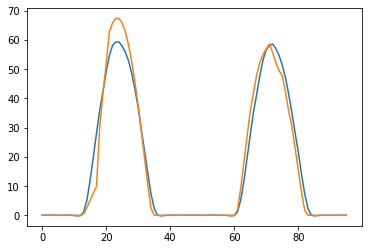

In [35]:
# 모델 사용하기
xhat = test_x[5]
print(xhat)
print(xhat.shape)
weights = model.get_weights()
single_item_model = Sequential()
for l in range(2):
    single_item_model.add(LSTM(64, batch_input_shape=(1, 336, 8), stateful=True, return_sequences=True))
    single_item_model.add(Dropout(0.3))
single_item_model.add(LSTM(64, batch_input_shape=(1, 336, 8), stateful=True))
single_item_model.add(Dropout(0.3))
single_item_model.add(Dense(96))  
single_item_model.set_weights(weights)
single_item_model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adam')

prediction = single_item_model.predict(np.array([xhat]), batch_size=1)
print(prediction)
print(prediction.shape)
print(max(prediction[0]))

plt.plot(np.reshape(prediction,(96)))
plt.plot(test_y[5])

In [24]:
model = Sequential()
for i in range(2):
    model.add(LSTM(128, batch_input_shape=(8, 336, 8), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(128, batch_input_shape=(8, 336, 8), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(96))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(500):
    # model.fit(train_x, train_y, epochs=1, batch_size=1, shuffle=False, validation_data=(val_x, val_y))
    model.fit(train_x, train_y, epochs=1, batch_size=8, shuffle=False, validation_data=(val_x, val_y))
    model.reset_states()

108/108 [==============================] - 4s 41ms/step - loss: 74.6229 - val_loss: 241.5640


[[ 0.          0.          0.         ...  2.         -6.97958958
   0.        ]
 [ 0.          0.          0.         ...  2.         -6.03649269
   0.        ]
 [ 0.          0.          0.         ...  2.         -6.8010495
   0.        ]
 ...
 [ 0.          0.          0.         ...  8.         -6.19348764
   0.        ]
 [ 0.          0.          0.         ...  8.         -6.87535672
   0.        ]
 [ 0.          0.          0.         ...  8.         -6.87535672
   0.        ]]
(336, 8)
[[-8.66117072e-04  1.67450646e-03  1.27642415e-03 -4.68828715e-03
   2.94265477e-03  1.16937989e-02  6.07891660e-03 -2.22043879e-03
   1.03669483e-02  1.53546873e-02 -3.09743360e-02  1.54104471e-01
   4.08835083e-01  2.84161925e+00  8.79239941e+00  1.70228920e+01
   2.56011143e+01  3.40888710e+01  4.26213837e+01  4.79267159e+01
   5.40237885e+01  5.72023697e+01  6.00307961e+01  5.93603706e+01
   5.87468758e+01  5.46619148e+01  5.19045105e+01  4.85877380e+01
   4.40286522e+01  3.92583466e+01  3.1

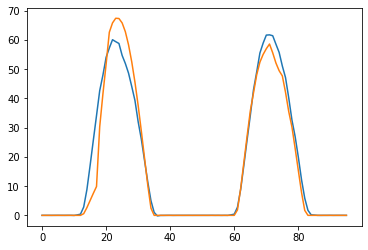

In [25]:
# 모델 사용하기
xhat = test_x[5]
print(xhat)
print(xhat.shape)
weights = model.get_weights()
single_item_model_1 = Sequential()
for l in range(2):
    single_item_model_1.add(LSTM(128, batch_input_shape=(1, 336, 8), stateful=True, return_sequences=True))
    single_item_model_1.add(Dropout(0.3))
single_item_model_1.add(LSTM(128, batch_input_shape=(1, 336, 8), stateful=True))
single_item_model_1.add(Dropout(0.3))
single_item_model_1.add(Dense(96))  
single_item_model_1.set_weights(weights)
single_item_model_1.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adam')

prediction = single_item_model_1.predict(np.array([xhat]), batch_size=1)
print(prediction)
print(prediction.shape)
print(max(prediction[0]))

plt.plot(np.reshape(prediction,(96)))
plt.plot(test_y[5])